In [1]:
%load_ext autoreload
%autoreload 2
import sys 
from FR3Py.robot.interface import FR3Real
robot = FR3Real(robot_id='fr3')

Interface Running...


In [2]:
robot.getStates()

{'q': array([-1.76492381e-04, -7.84305475e-01,  3.00503269e-03, -2.38068503e+00,
        -1.37254908e-03,  1.57106282e+00,  7.86085504e-01]),
 'dq': array([ 2.31240918e-04,  1.14583636e-04, -1.07089613e-03,  7.86633761e-04,
         5.11362018e-05,  3.36238876e-04, -3.43246513e-04]),
 'T': array([ 0.11434627, -4.24646139, -0.85097349, 23.22269058,  1.08873212,
         2.10843635, -0.0571954 ])}

In [3]:
import numpy as np
from FR3Py.robot.model_collision_avoidance import PinocchioModel
import time

pin_robot = PinocchioModel()
joint_lb = np.array([-2.3093, -1.5133, -2.4937, -2.7478, -2.48, 0.8521, -2.6895])
joint_ub = np.array([2.3093, 1.5133, 2.4937, -0.4461, 2.48, 4.2094, 2.6895])
n_joints = 7
q_bar = 0.5*(joint_ub + joint_lb)
P_EE_desired = np.array([0.42, 0.50, 0.00])
R_EE_desired = np.array([[1, 0, 0],
                        [0, -1, 0],
                        [0, 0, -1]])
P_EE_initial = np.array([0.30, 0.0, 0.47])

### Inverse dynamic control (initial pose to pre-cleaning pose)

In [4]:
from cores.utils.trajectory_utils import TrapezoidalTrajectory

via_points = np.array([P_EE_initial, P_EE_desired])
target_time = np.array([0, 10])
traj = TrapezoidalTrajectory(via_points, target_time, T_antp=0.2, Ts=0.01)

In [5]:
from cores.utils.control_utils import get_torque_to_track_traj_const_ori

T = 12

Kp_task = np.diag([40,40,40,100,100,100])
Kd_task = np.diag([40,40,40,100,100,100])

Kp_joint = np.diag([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])*10
Kd_joint = np.diag([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])*10

delta = 0.1

t_start = time.time()
while time.time() - t_start < T:
    t = time.time() - t_start
    traj_pos, traj_vel, traj_acc = traj.get_traj_and_ders(t)

    q = 0.025*np.ones(9)
    dq = np.zeros(9)
    robot_info = robot.getStates()
    q[0:n_joints] = robot_info['q']
    dq[0:n_joints] = robot_info['dq']

    pin_info = pin_robot.getInfo(q, dq)
    q = q[0:n_joints]
    dq = dq[0:n_joints]
    P_EE = pin_info["P_EE"]
    R_EE = pin_info["R_EE"]
    J_EE = pin_info["J_EE"][:,0:n_joints] # shape (6,7)
    dJdq_EE = pin_info["dJdq_EE"] # shape (6,)
    v_EE = J_EE @ dq # shape (6,)
    M = pin_info["M"][0:n_joints,0:n_joints] + delta*np.eye(n_joints) # shape (7,7)
    # Minv = pin_info["Minv"][0:n_joints,0:n_joints]   # shape (7,7)
    Minv = np.linalg.inv(M)
    nle = pin_info["nle"][0:n_joints]  # shape (7,)
    G = pin_info["G"][0:n_joints]  # shape (7,)

    S, u_task = get_torque_to_track_traj_const_ori(traj_pos, traj_vel, traj_acc, R_EE_desired, Kp_task, Kd_task, Minv, J_EE, dJdq_EE, dq, P_EE, R_EE)

    # Secondary objective: encourage the joints to remain close to the initial configuration
    W = np.diag(1.0/(joint_ub-joint_lb))
    eq = W @ (q - q_bar)
    deq = W @ dq
    u_joint = M @ (- Kd_joint @ deq - Kp_joint @ eq) 

    # Compute the input torque
    Spinv = S.T @ np.linalg.pinv(S @ S.T + 0.01* np.eye(S.shape[0]))
    u_nominal =  Spinv @ u_task + (np.eye(len(q)) - Spinv @ S) @ u_joint
    u = np.clip(u_nominal, -20, 20)
    robot.setCommands(u)

robot.setCommands(np.zeros_like(u))


### (Optional) Press against the surface while maintaining only orientation

In [ ]:
from cores.utils.control_utils import get_torque_to_track_const_ori

T = 1000

Kp_task = np.diag([0,0,100])
Kd_task = np.diag([0,0,100])

Kd_joint = np.diag([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])*10
# F_ext = np.array([0, 0, -15, 0, 0, 0])
F_ext = np.array([0, 0, 0, 0, 0, 0])

delta = 0.1

t_start = time.time()
while time.time() - t_start < T:
    t = time.time() - t_start
    
    q = 0.025*np.ones(9)
    dq = np.zeros(9)
    robot_info = robot.getStates()
    q[0:n_joints] = robot_info['q']
    dq[0:n_joints] = robot_info['dq']

    pin_info = pin_robot.getInfo(q, dq)
    q = q[0:n_joints]
    dq = dq[0:n_joints]
    P_EE = pin_info["P_EE"]
    R_EE = pin_info["R_EE"]
    J_EE = pin_info["J_EE"][:,0:n_joints] # shape (6,7)
    dJdq_EE = pin_info["dJdq_EE"] # shape (6,)
    v_EE = J_EE @ dq # shape (6,)
    M = pin_info["M"][0:n_joints,0:n_joints] + delta*np.eye(n_joints) # shape (7,7)
    # Minv = pin_info["Minv"][0:n_joints,0:n_joints]   # shape (7,7)
    Minv = np.linalg.inv(M)
    nle = pin_info["nle"][0:n_joints]  # shape (7,)
    G = pin_info["G"][0:n_joints]  # shape (7,)

    S, u_task = get_torque_to_track_const_ori(R_EE_desired, Kp_task, Kd_task, Minv, J_EE, dJdq_EE, dq, R_EE)

    # Second objective: apply a force on the z axis to press the end-effector against the table
    u_press = J_EE.T @ F_ext

    # Third objective: encourage the joints to have zero velocity
    W = np.diag(1.0/(joint_ub-joint_lb))
    deq = W @ dq
    u_joint = M @ (-Kd_joint @ deq) 

    # Compute the input torque
    Spinv = S.T @ np.linalg.pinv(S @ S.T + 0.01* np.eye(S.shape[0]))
    u_nominal =  Spinv @ u_task + (np.eye(len(q)) - Spinv @ S) @ u_joint + u_press
    u = np.clip(u_nominal, -20, 20)
    robot.setCommands(u)

robot.setCommands(np.zeros_like(u))

### Press against the surface while tracking a circular trajectory

In [10]:
from cores.utils.trajectory_utils import CircularTrajectory
duration = 100
P_start_point = np.array([0.42, 0.50, 0.0])
P_center = np.array([0.32, 0.50, 0.0])
nominal_linear_vel = 0.05
R_b_to_w = np.eye(3)
traj = CircularTrajectory(P_center, P_start_point, nominal_linear_vel, R_b_to_w, duration)


In [11]:
T = 60

Kp_task = np.diag([40,40,40,60,60,100])
Kd_task = np.diag([30,30,30,20,20,75])

Kp_joint = np.diag([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])*200
Kd_joint = np.diag([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])*160

F_ext = np.array([0, 0, -10, 0, 0, 0])

delta = 0.1

# Records
pos_list = []
u_nominal_list = []
t_list = []

t_start = time.time()
while time.time() - t_start < T:
    t = time.time() - t_start
    traj_pos, traj_vel, traj_acc = traj.get_traj_and_ders(t)

    q = 0.025*np.ones(9)
    dq = np.zeros(9)
    robot_info = robot.getStates()
    q[0:n_joints] = robot_info['q']
    dq[0:n_joints] = robot_info['dq']

    pin_info = pin_robot.getInfo(q, dq)
    q = q[0:n_joints]
    dq = dq[0:n_joints]
    P_EE = pin_info["P_EE"]
    R_EE = pin_info["R_EE"]
    J_EE = pin_info["J_EE"][:,0:n_joints] # shape (6,7)
    dJdq_EE = pin_info["dJdq_EE"] # shape (6,)
    v_EE = J_EE @ dq # shape (6,)
    M = pin_info["M"][0:n_joints,0:n_joints] + delta*np.eye(n_joints) # shape (7,7)
    # Minv = pin_info["Minv"][0:n_joints,0:n_joints]   # shape (7,7)
    Minv = np.linalg.inv(M)
    nle = pin_info["nle"][0:n_joints]  # shape (7,)
    G = pin_info["G"][0:n_joints]  # shape (7,)

    S, u_task = get_torque_to_track_traj_const_ori(traj_pos, traj_vel, traj_acc, R_EE_desired, Kp_task, Kd_task, Minv, J_EE, dJdq_EE, dq, P_EE, R_EE)

    # Second objective: apply a force on the z axis to press the end-effector against the table
    u_press = J_EE.T @ F_ext

    # Third objective: encourage the joints to remain close to the initial configuration
    W = np.diag(1.0/(joint_ub-joint_lb))
    eq = W @ (q - q_bar)
    deq = W @ dq
    u_joint = M @ (- Kd_joint @ deq - Kp_joint @ eq) 

    # Compute the input torque
    Spinv = S.T @ np.linalg.pinv(S @ S.T + 0.01* np.eye(S.shape[0]))
    u_nominal =  Spinv @ u_task + (np.eye(len(q)) - Spinv @ S) @ u_joint + u_press
    u = np.clip(u_nominal, -10, 10)
    robot.setCommands(u)

    t_list.append(t)
    pos_list.append(P_EE)
    u_nominal_list.append(u_nominal)

robot.setCommands(np.zeros_like(u))

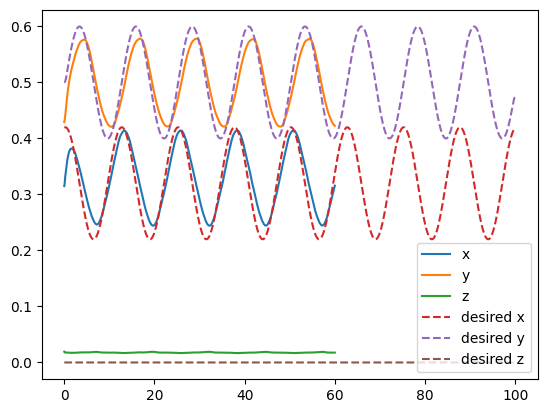

In [12]:
import matplotlib.pyplot as plt

pos_list = np.array(pos_list)
u_nominal_list = np.array(u_nominal_list)
t_list = np.array(t_list)

plt.figure()
plt.plot(t_list, pos_list[:,0], label='x')
plt.plot(t_list, pos_list[:,1], label='y')
plt.plot(t_list, pos_list[:,2], label='z')
plt.plot(traj.t, traj.pd[:,0], '--', label='desired x')
plt.plot(traj.t, traj.pd[:,1], '--', label='desired y')
plt.plot(traj.t, traj.pd[:,2], '--', label='desired z')
plt.legend()


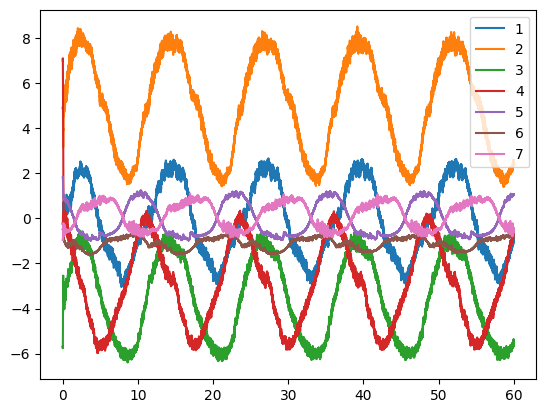

In [13]:

plt.figure()
plt.plot(t_list, u_nominal_list[:,0], label='1')
plt.plot(t_list, u_nominal_list[:,1], label='2')
plt.plot(t_list, u_nominal_list[:,2], label='3')
plt.plot(t_list, u_nominal_list[:,3], label='4')
plt.plot(t_list, u_nominal_list[:,4], label='5')
plt.plot(t_list, u_nominal_list[:,5], label='6')
plt.plot(t_list, u_nominal_list[:,6], label='7')

plt.legend()

### Press against the surface while tracking a circular trajectory with friction compensation

In [14]:
from cores.utils.trajectory_utils import CircularTrajectory
duration = 100
P_start_point = np.array([0.42, 0.50, -0.01])
P_center = np.array([0.32, 0.50, -0.01])
nominal_linear_vel = 0.05
R_b_to_w = np.eye(3)
traj = CircularTrajectory(P_center, P_start_point, nominal_linear_vel, R_b_to_w, duration, Ts=0.01)

In [20]:
T = 60

Kp_task = np.diag([40,40,40,100,100,100])
Kd_task = np.diag([30,30,30,50,50,75])
Kp_joint = np.diag([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])*200
Kd_joint = np.diag([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])*160
F_press = np.array([0, 0, -10, 0, 0, 0])
mu_friction = 2.5/9.81 + 0.05
delta = 0.1

# Records
pos_list = []
u_nominal_list = []
t_list = []

t_start = time.time()
while time.time() - t_start < T:
    t = time.time() - t_start
    traj_pos, traj_vel, traj_acc = traj.get_traj_and_ders(t)

    q = 0.025*np.ones(9)
    dq = np.zeros(9)
    robot_info = robot.getStates()
    q[0:n_joints] = robot_info['q']
    dq[0:n_joints] = robot_info['dq']

    pin_info = pin_robot.getInfo(q, dq)
    q = q[0:n_joints]
    dq = dq[0:n_joints]
    tau_m = robot_info["T"] # shape (6,)
    P_EE = pin_info["P_EE"]
    R_EE = pin_info["R_EE"]
    J_EE = pin_info["J_EE"][:,0:n_joints] # shape (6,7)
    dJdq_EE = pin_info["dJdq_EE"] # shape (6,)
    v_EE = J_EE @ dq # shape (6,)
    M = pin_info["M"][0:n_joints,0:n_joints] + delta*np.eye(n_joints) # shape (7,7)
    # Minv = pin_info["Minv"][0:n_joints,0:n_joints]   # shape (7,7)
    Minv = np.linalg.inv(M)
    nle = pin_info["nle"][0:n_joints]  # shape (7,)
    G = pin_info["G"][0:n_joints]  # shape (7,)
    tau_ext = tau_m - nle

    S, u_task = get_torque_to_track_traj_const_ori(traj_pos, traj_vel, traj_acc, R_EE_desired, Kp_task, Kd_task, Minv, J_EE, dJdq_EE, dq, P_EE, R_EE)

    # Second objective 1: apply a force on the z axis to press the end-effector against the table
    u_press = J_EE.T @ F_press

    # Second objective 2: apply a force to compensate for the friction
    F_ext = np.linalg.pinv(J_EE.T) @ tau_ext
    z_force = F_ext[2]
    if z_force <= 0:
        friction = mu_friction * np.abs(z_force)
        direction = v_EE[0:2]/np.linalg.norm(v_EE[0:2])
        F_friction = np.zeros(6)
        F_friction[0:2] = direction * friction
        u_friction = J_EE.T @ F_friction
    else:
        u_friction = np.zeros(n_joints)

    # Third objective: encourage the joints to remain close to the initial configuration
    W = np.diag(1.0/(joint_ub-joint_lb))
    eq = W @ (q - q_bar)
    deq = W @ dq
    u_joint = M @ (- Kd_joint @ deq - Kp_joint @ eq) 

    # Compute the input torque
    Spinv = S.T @ np.linalg.pinv(S @ S.T + 0.01* np.eye(S.shape[0]))
    u_nominal =  Spinv @ u_task + (np.eye(len(q)) - Spinv @ S) @ u_joint + u_press + u_friction
    u = np.clip(u_nominal, -10, 10)
    robot.setCommands(u)

    t_list.append(t)
    pos_list.append(P_EE)
    u_nominal_list.append(u_nominal)

robot.setCommands(np.zeros_like(u))


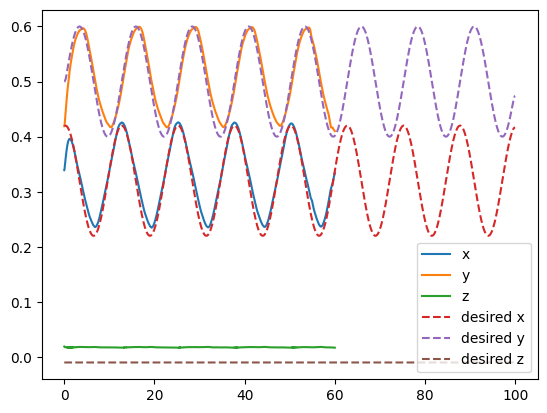

In [21]:
import matplotlib.pyplot as plt

pos_list = np.array(pos_list)
u_nominal_list = np.array(u_nominal_list)
t_list = np.array(t_list)

plt.figure()
plt.plot(t_list, pos_list[:,0], label='x')
plt.plot(t_list, pos_list[:,1], label='y')
plt.plot(t_list, pos_list[:,2], label='z')
plt.plot(traj.t, traj.pd[:,0], '--', label='desired x')
plt.plot(traj.t, traj.pd[:,1], '--', label='desired y')
plt.plot(traj.t, traj.pd[:,2], '--', label='desired z')
plt.legend()



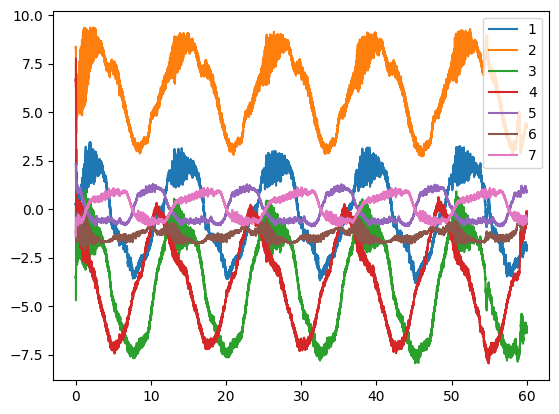

In [22]:

plt.figure()
plt.plot(t_list, u_nominal_list[:,0], label='1')
plt.plot(t_list, u_nominal_list[:,1], label='2')
plt.plot(t_list, u_nominal_list[:,2], label='3')
plt.plot(t_list, u_nominal_list[:,3], label='4')
plt.plot(t_list, u_nominal_list[:,4], label='5')
plt.plot(t_list, u_nominal_list[:,5], label='6')
plt.plot(t_list, u_nominal_list[:,6], label='7')

plt.legend()


### Recover to initial pose

In [24]:
via_points = np.array([P_EE, np.array([P_EE[0], P_EE[1], P_EE[2]+0.2])])
target_time = np.array([0, 5])
traj = TrapezoidalTrajectory(via_points, target_time, T_antp=0.2, Ts=0.01)

In [25]:
T = 7

Kp_task = np.diag([40,40,40,100,100,100])
Kd_task = np.diag([40,40,40,100,100,100])

Kp_joint = np.diag([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])*10
Kd_joint = np.diag([0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5])*10

delta = 0.1

t_start = time.time()
while time.time() - t_start < T:
    t = time.time() - t_start
    traj_pos, traj_vel, traj_acc = traj.get_traj_and_ders(t)

    q = 0.025*np.ones(9)
    dq = np.zeros(9)
    robot_info = robot.getStates()
    q[0:n_joints] = robot_info['q']
    dq[0:n_joints] = robot_info['dq']

    pin_info = pin_robot.getInfo(q, dq)
    q = q[0:n_joints]
    dq = dq[0:n_joints]
    P_EE = pin_info["P_EE"]
    R_EE = pin_info["R_EE"]
    J_EE = pin_info["J_EE"][:,0:n_joints] # shape (6,7)
    dJdq_EE = pin_info["dJdq_EE"] # shape (6,)
    v_EE = J_EE @ dq # shape (6,)
    M = pin_info["M"][0:n_joints,0:n_joints] + delta*np.eye(n_joints) # shape (7,7)
    # Minv = pin_info["Minv"][0:n_joints,0:n_joints]   # shape (7,7)
    Minv = np.linalg.inv(M)
    nle = pin_info["nle"][0:n_joints]  # shape (7,)
    G = pin_info["G"][0:n_joints]  # shape (7,)

    S, u_task = get_torque_to_track_traj_const_ori(traj_pos, traj_vel, traj_acc, R_EE_desired, Kp_task, Kd_task, Minv, J_EE, dJdq_EE, dq, P_EE, R_EE)

    # Secondary objective: encourage the joints to remain close to the initial configuration
    W = np.diag(1.0/(joint_ub-joint_lb))
    eq = W @ (q - q_bar)
    deq = W @ dq
    u_joint = M @ (- Kd_joint @ deq - Kp_joint @ eq) 

    # Compute the input torque
    Spinv = S.T @ np.linalg.pinv(S @ S.T + 0.01* np.eye(S.shape[0]))
    u_nominal =  Spinv @ u_task + (np.eye(len(q)) - Spinv @ S) @ u_joint
    u = np.clip(u_nominal, -20, 20)
    robot.setCommands(u)

robot.setCommands(np.zeros_like(u))